In [70]:
import os
import warnings
from pathlib import Path

import catboost
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier, Pool
from dotenv import load_dotenv
from sklearn.metrics import roc_auc_score

import src.features.basic as ftr_basic
import src.utils.io as io_utils
import src.visualization.plotting as visual

In [47]:
load_dotenv()
warnings.filterwarnings("ignore")
%matplotlib inline
%load_ext autoreload
%autoreload 2


ROOT = Path(os.getenv("ROOT"))
CONFIG_DIR = ROOT / Path("src/config/")
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [48]:
data_cfg = io_utils.load_yaml(CONFIG_DIR / "data.yaml")
DATA_NEW_FTR = data_cfg["new_features_train_data"]

data_train = io_utils.load_df_parquet(ROOT / DATA_NEW_FTR["train_new_features_path"])
data_val = io_utils.load_df_parquet(ROOT / DATA_NEW_FTR["val_new_features_path"])

target_train = io_utils.load_df_parquet(ROOT / DATA_NEW_FTR["train_target_path"])
target_val = io_utils.load_df_parquet(ROOT / DATA_NEW_FTR["val_target_path"])

data_train.head()

,age,job,marital,education,contact,poutcome,was_contact,credit_score,job_marital,job_education,...,previous_cat,log_duration,log_balance,multiply_logs,is_overdraft,sin_month,cos_month,sin_day,cos_day,jb_mean
0,30,blue-collar,married,primary,unknown,unknown,0,1,blue-collar_married,blue-collar_primary,...,0,5.697093,7.300473,41.591476,0,0.866025,-0.500000,0.299363,-0.954139,972.500400
1,33,technician,divorced,secondary,cellular,unknown,0,0,technician_divorced,technician_secondary,...,0,6.137727,3.871201,23.760375,0,-0.500000,-0.866025,0.937752,0.347305,1073.106634
2,28,blue-collar,single,primary,telephone,unknown,0,1,blue-collar_single,blue-collar_primary,...,0,6.276643,6.318968,39.661910,0,0.866025,-0.500000,0.651372,-0.758758,972.500400
3,29,unemployed,single,primary,cellular,unknown,0,0,unemployed_single,unemployed_primary,...,0,5.468060,7.635787,41.752942,0,0.500000,0.866025,0.394356,0.918958,1429.215033
4,55,technician,married,secondary,cellular,success,1,1,technician_married,technician_secondary,...,<5,6.419995,6.763885,43.424107,0,0.500000,-0.866025,0.988468,0.151428,1073.106634


In [49]:
ftr_names = ftr_basic.get_features_names(data_train)
cat_features, num_features = ftr_names["categorical"], ftr_names["numeric"]

data_train = ftr_basic.cat_features_to_category(data_train)
data_val = ftr_basic.cat_features_to_category(data_val)

data_train, data_val = ftr_basic.align_categorical_levels(
    data_train, data_val, cat_features
)

In [65]:
data_ids = io_utils.load_df_parquet(
    ROOT / data_cfg["origin_train_data_clean"]["ids_path"]
)

In [50]:
cat_features

['job',
 'marital',
 'education',
 'contact',
 'poutcome',
 'job_marital',
 'job_education',
 'education_marital',
 'campaign_cat',
 'pdays_cat',
 'previous_cat']

In [51]:
model_cfg = io_utils.load_yaml(CONFIG_DIR / "models.yml")["catboost_searh"]

PARAMS_PATH = ROOT / model_cfg["params_path"]
cb_params = io_utils.load_yaml(PARAMS_PATH)
cb_base_params = cb_params["base_model_params"]
cb_random_params = cb_params["randomized"]

cb_random_params

{'param_distributions': {'depth': [5, 6, 7, 8],
  'learning_rate': [0.02, 0.03, 0.04, 0.05, 0.06],
  'l2_leaf_reg': [2, 3, 5, 7, 10, 15, 20],
  'min_data_in_leaf': [1, 10, 20, 50, 100],
  'bagging_temperature': [0.0, 0.5, 0.1],
  'random_strength': [0.0, 0.5, 1.0],
  'rsm': [0.8, 0.9, 1.0]},
 'n_iter': 24,
 'cv': 3,
 'stratified': True,
 'shuffle': True,
 'partition_random_seed': 42,
 'calc_cv_statistics': True,
 'refit': True,
 'verbose': True}

In [52]:
base_cb_model = CatBoostClassifier(**cb_base_params)

train_pool = Pool(data_train, target_train, cat_features)
val_pool = Pool(data_val, target_val, cat_features)

In [53]:
%%time

result = base_cb_model.randomized_search(X=train_pool, **cb_random_params)
best_cb_model = base_cb_model.copy()

result.save_model(ROOT / model_cfg["model_path"])

CPU times: user 28.6 s, sys: 1.59 s, total: 30.2 s
Wall time: 5.45 s


KeyboardInterrupt: 

In [55]:
model = CatBoostClassifier()
best_model = model.load_model(ROOT / model_cfg["model_path"])

In [56]:
best_model.get_params()

{'rsm': 0.9,
 'random_strength': 0.5,
 'allow_writing_files': False,
 'eval_metric': 'AUC',
 'od_wait': 200,
 'od_type': 'Iter',
 'verbose': 0,
 'iterations': 6000,
 'bagging_temperature': 0.5,
 'auto_class_weights': 'Balanced',
 'loss_function': 'Logloss',
 'l2_leaf_reg': 3,
 'depth': 6,
 'min_data_in_leaf': 20,
 'learning_rate': 0.05,
 'random_seed': 42}

In [58]:
best_params_cb = best_model.get_params()
best_iter_cb = best_model.get_best_iteration()
print("best_params: ", {k: best_params_cb[k] for k in param_grid})
print(f"best iteration: {best_iter_cb}")

pred_best_cb = best_model.predict_proba(val_pool)[:, 1]
print(f"Best CatBoost AUC: {roc_auc_score(target_val, pred_best_cb):.4f}")

best_params:  {'depth': 6, 'learning_rate': 0.05, 'l2_leaf_reg': 3, 'min_data_in_leaf': 20, 'bagging_temperature': 0.5, 'random_strength': 0.5, 'rsm': 0.9}
best iteration: None
Best CatBoost AUC: 0.9675


In [59]:
%%time

val_model = CatBoostClassifier(**best_params_cb)

val_model.fit(
    train_pool,
    eval_set=val_pool,
    use_best_model=True,
    early_stopping_rounds=200,
    verbose=0,
)

CPU times: user 5h 6min 21s, sys: 11min 51s, total: 5h 18min 13s
Wall time: 51min 6s


In [61]:
best_params_cb = best_model.get_params()
best_iter_cb = best_model.get_best_iteration()

pred_best_cb = best_model.predict_proba(val_pool)[:, 1]
auc = roc_auc_score(target_val, pred_best_cb)
print(f"Best CatBoost AUC: {auc:.4f}")

Best CatBoost AUC: 0.9675


In [63]:
meta = {
    "library": "catboost",
    "version": catboost.__version__,
    "base_params": cb_base_params,
    "randomized_search_params": cb_random_params,
    "best_search_params": best_params_cb,
    "best_iteration": int(val_model.get_best_iteration()),
    "tree_count": int(val_model.tree_count_),
    "feature_order": list(data_train.columns),
    "categorical_features": list(cat_features),
}

io_utils.save_yaml(meta, ROOT / model_cfg["meta_path"])

In [66]:
metrics = {"auc_val": float(auc)}
preds_df = pd.DataFrame(
    {
        "val_ids": data_ids.loc[data_val.index, "id"],
        "val_preds": pred_best_cb,
        "val_true": target_val.squeeze(),
    }
)

io_utils.save_df_parquet(preds_df, ROOT / model_cfg["preds_path"])
io_utils.save_yaml(metrics, ROOT / model_cfg["metrics_path"])

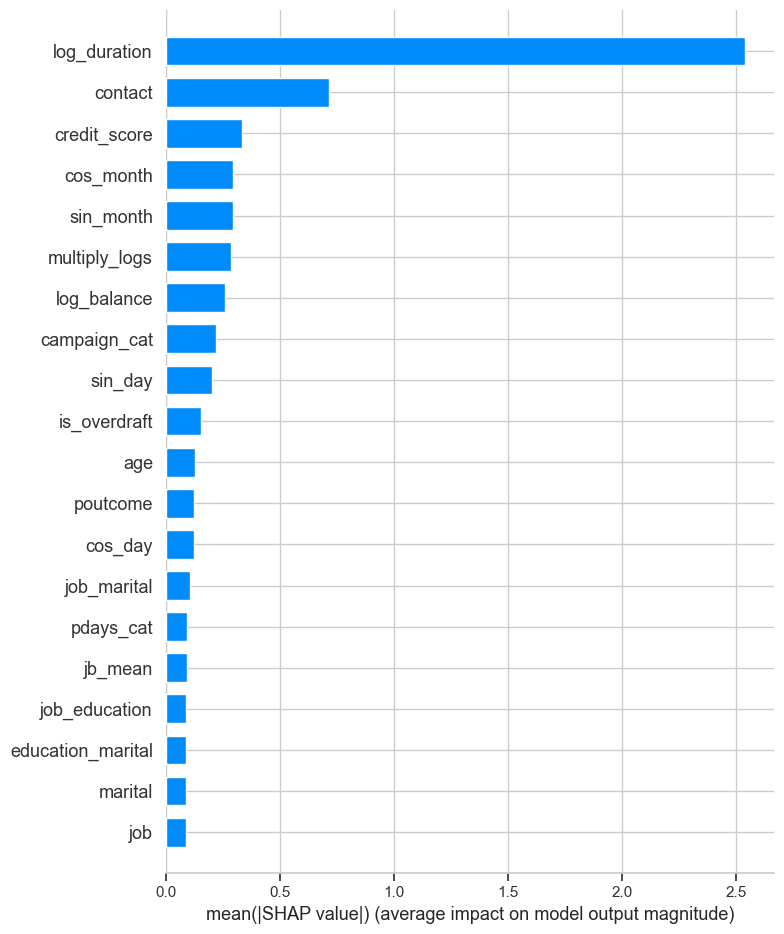

,feature,shap_value
14,log_duration,2.539566
4,contact,0.712676
7,credit_score,0.330524
19,cos_month,0.292171
18,sin_month,0.291012
16,multiply_logs,0.285807
15,log_balance,0.258897
11,campaign_cat,0.219593
20,sin_day,0.201809
17,is_overdraft,0.150891


In [68]:
shap_values = visual.shap_values(best_model, data_train)

shap_values